# JCAP images & spectra hackathon
## Intro and motivation
This notebook gives an introduction to the dataset used in the research presented in Stein et al. Chem. Sci., 2019, 10, 47-55 https://doi.org/10.1039/C8SC03077D to generate embeddings from printed images and use them to predict full UV-Vis absorption spectra. The bigger picture for this scientific endeavour is the quest to find materials that are able to split water under irradiation of sunlight (solar water splitting) to generate renewable "solar" fuels. The scientists in the high-throughput experiementation group (HTE) at the Joint Center for Artificial Photosynthesis (JCAP - https://solarfuelshub.org/) therefore utilize ink-jet printing to deposit metal nitrate precursors onto transparent conducting oxides (TCO) that are annealed at high temperatures to form metal oxides. The images in this study (already encoded using a neural network in the dataset here) are optical microscopy images from a consumer grade photo scanner that is able to scan tens of thousands of materials images (ca. 4mm by 4mm) a minute. The information in these images is classic RGB CMOS data. Being able to tell from this very low-cost measurement how the full absorption spectra would qualitatively and quantitaively look like would not just enable the scientists to accelerate their discovery process but to also allow them to use the giant amount of materials images that have never been measured using UV-Vis spectroscopy.
The measurement workflow is shown below.


<img src="./jcap_workflow.png" alt="workflow" width="500">


## Technical introduction / reference

**THIS IS FOR REFERENCE, THERE IS NO NEED TO DOWNLOAD FROM THE EXTERNAL SITE** In their publication Stein et al. used a convolutional variational autoencoder to generate image embeddings, that for the purpose of this notebook, shall function as a surrogate representation of the images. What you have in this notebook is the embeddings for a subset of the over 100k images described by Stein et al. in https://doi.org/10.1038/s41597-019-0019-4 that can be downloaded at https://data.caltech.edu/records/1152 with code to wrangle with the dataset available at https://github.com/helgestein/materials-images-spectra. 
The embeddings for images are already generated for you as this process requires training of a larger deep neural network and takes about 30 min to complete. 

**For the bandgap prediction a word of precaution should be made:** We calculate the bandgap only for those spectra where reasonable values were found for both the predicted and regressed bandgaps. The used algorithm for bandgap extraction is not very stable and can predict bandgaps outside a physically meaningful range. Also, we know that most materials are multiphase thus exhibit more than one bandgap. The algorithm finds the most dominant one.

# Load packages and files

In [20]:
%matplotlib inline
import os
import boto3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

Download files to SageMaker instance from S3.

In [21]:
jcap_pickle = 'jcap_optical_encoding.pickle'
energy_npy = 'energy_ev.npy'

In [22]:
def hook(t):
  def inner(bytes_amount):
    t.update(bytes_amount)
  return inner
#session = boto3.session.Session(profile_name='hack2020')
#s3 = session.client('s3')
s3 = boto3.client('s3')
for filename in [jcap_pickle, energy_npy]:
    filesize = boto3.resource('s3').Object('hackathon2020-prod', 'data/' + filename).content_length
    with tqdm(total=filesize, unit='B', unit_scale=True, desc=jcap_pickle) as t:
        s3.download_file('hackathon2020-prod', 'data/' + filename, filename, Callback=hook(t))

jcap_optical_encoding.pickle: 100%|██████████| 154M/154M [00:01<00:00, 151MB/s]  
jcap_optical_encoding.pickle: 100%|██████████| 1.01k/1.01k [00:00<00:00, 30.4kB/s]


Load local files into arrays or Pandas dataframe.

In [23]:
energy_ev = np.load(energy_npy)
jcap_df = pd.read_pickle(jcap_pickle)
jcap_df.shape

(100430, 45)

Look at the first few rows of the dataframe.

In [24]:
jcap_df.head()

,bandgap,vae,spectrum,Fe,Sn,Ti,Zn,Ce,Co,Ni,...,Ba,Yb,P,Sc,Ag,Tb,Nd,Pd,Hf,Rb
comp_id,,,,,,,,,,,,,,,,,,,,,
0,1.755781,"[-0.31556356, 0.08774113, -0.8520775, -0.31919...","[0.10790491, 0.10887808, 0.10989829, 0.1109349...",0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.742198,"[-0.12112557, 0.24288416, -0.9173074, -0.15820...","[0.11588116, 0.1168056, 0.117843196, 0.1188294...",0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.771895,"[-0.04941248, 0.16220033, -0.712603, -0.112917...","[0.106575124, 0.10763326, 0.10877366, 0.109730...",0.05,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.771431,"[0.0121279415, 0.21519777, -0.9823824, -0.0944...","[0.116964534, 0.117831506, 0.11866215, 0.11943...",0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.791558,"[-0.086630665, 0.18296382, -0.90706384, -0.095...","[0.10127419, 0.102086134, 0.102931604, 0.10381...",0.05,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The dataframe is indexed with an entry id associated with a unique composition. The bandgap, 100-dimensional encoding from variational autoencoder in the reference, the optical-UV spectrum, and the atomic fraction of each element are listed for each entry.

In [35]:
jcap_df.columns

Index(['bandgap', 'vae', 'spectrum', 'Fe', 'Sn', 'Ti', 'Zn', 'Ce', 'Co', 'Ni',
       'Bi', 'V', 'Cu', 'Mn', 'W', 'Mo', 'La', 'Cr', 'Y', 'Er', 'Sr', 'Gd',
       'Sm', 'Sb', 'Nb', 'Ga', 'In', 'Al', 'Pb', 'Mg', 'Ca', 'Pr', 'Eu', 'Zr',
       'Lu', 'Ba', 'Yb', 'P', 'Sc', 'Ag', 'Tb', 'Nd', 'Pd', 'Hf', 'Rb'],
      dtype='object')

Here we plot a histogram of all the bandgaps over the entire dataset.

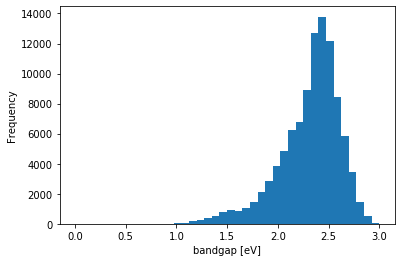

In [38]:
jcap_df['bandgap'].plot.hist(bins=40,range=[0,3])
plt.xlabel('bandgap [eV]')
plt.savefig('bandgap_hist.png')

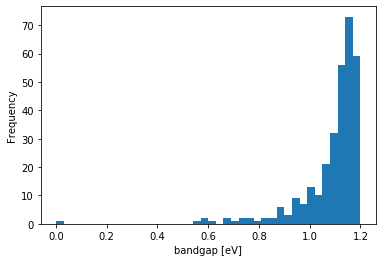

In [37]:
jcap_df['bandgap'].plot.hist(bins=40,range=[0,1.2])
plt.xlabel('bandgap [eV]')
plt.savefig('bandgap_hist_zoom.png')

Here we inspect the properties of a single entry (106). The optical-UV spectrum is shown over the range in array `energy_ev`, a histogram of coefficients from the encoding is plotted, and we print the elements with non-zero atomic fraction.

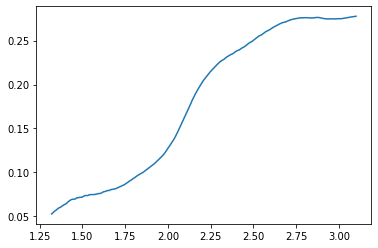

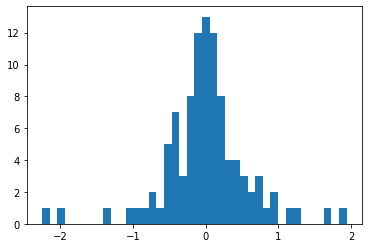

101 Fe 0.3
101 Bi 0.35
101 Mn 0.35


In [14]:
entry_id = 101
plt.plot(energy_ev, jcap_df.loc[entry_id, 'spectrum'])
plt.show()
plt.hist(jcap_df.loc[entry_id, 'vae'], bins=40)
plt.show()
for col in jcap_df.columns:
    if len(col) > 2:
        continue
    if jcap_df.loc[entry_id, col] > 1e-6:
        print(entry_id, col, jcap_df.loc[entry_id, col])